In [52]:
# dataframes & arrays
import pandas as pd
import numpy as np
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
# clear warnings
import warnings
warnings.filterwarnings("ignore")
# request
import requests
# metrics
from sklearn import metrics
# scripts
import env

In [53]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [54]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'   
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [55]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = pd.concat([df,new])

df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp)
df = df.set_index('timestamp')

In [56]:
ip1 = df.set_index('ip')

<Axes: xlabel='ip'>

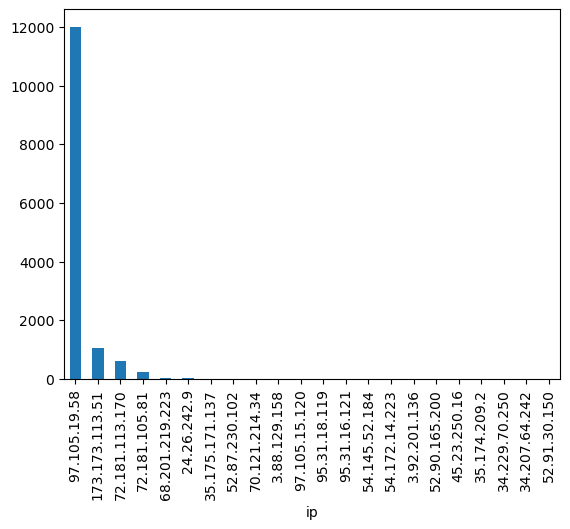

In [57]:
ip1.value_counts('ip').plot(kind='bar')

<Axes: xlabel='size_mb'>

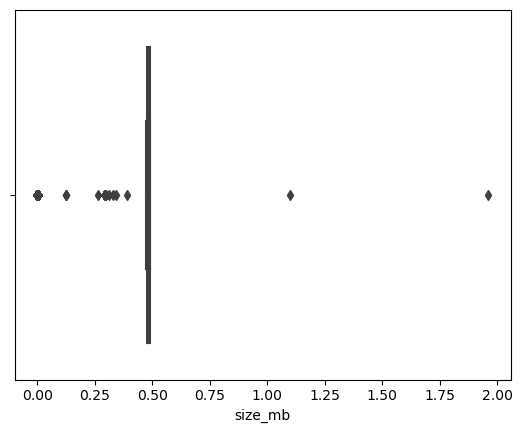

In [99]:
#
sns.boxplot(data=ip1, x='size_mb')

<Axes: >

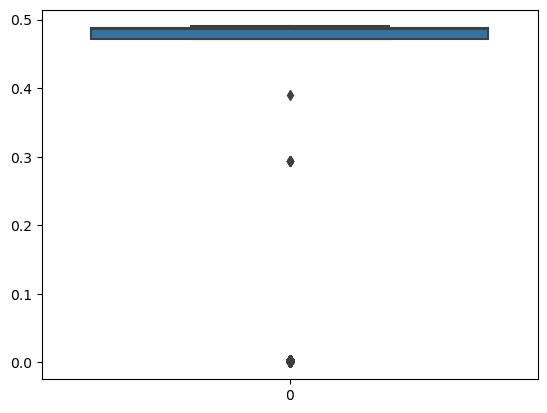

In [118]:
ip2 = ip1.size_mb.drop(index=(ip1.index[ip1.size_mb > 1]))
sns.boxplot(data=ip2)

In [58]:
ip_grouped = pd.DataFrame(index=ip1.index.unique())

In [59]:
ip_grouped['avg_size'] = ip1.groupby('ip')['size_mb'].mean().sort_values()
ip_grouped['max_size'] = ip1.groupby('ip')['size_mb'].max().sort_values()
ip_grouped['count_req'] = ip1.groupby('ip')['request_method'].count().sort_values()



In [60]:
# Checking average size of activity by ip address
ip_grouped.sort_values('max_size',ascending=False)

# 95.31.18.119 has 1 request for 1.09 mbs, which may be some sort of indicator

,avg_size,max_size,count_req
ip,,,
97.105.19.58,0.438530,1.961066,11999
95.31.18.119,1.099591,1.099591,1
173.173.113.51,0.373481,0.489937,1059
72.181.113.170,0.401429,0.489937,613
72.181.105.81,0.366913,0.489937,246
24.26.242.9,0.158562,0.471025,21
52.87.230.102,0.235590,0.471025,2
68.201.219.223,0.002184,0.003489,21
3.88.129.158,0.003396,0.003396,1


In [70]:
# investigating the api v1 items page, there could be large items on this page
ip1[ip1.index == '95.31.18.119']

,request_method,request_path,http_version,status_code,size,user_agent,size_mb
ip,,,,,,,
95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591


In [71]:
# it is also the only request to this page
ip1[ip1.request_path == '/api/v1/items/']

,request_method,request_path,http_version,status_code,size,user_agent,size_mb
ip,,,,,,,
95.31.18.119,GET,/api/v1/items/,HTTP/1.1,200,1153005,python-requests/2.21.0,1.099591


In [62]:
# status codes by individual ip

ip1.groupby(ip1.index)['status_code'].value_counts().sort_index()

ip              status_code
173.173.113.51  200             1059
24.26.242.9     200               21
3.88.129.158    200                1
3.92.201.136    200                1
34.207.64.242   200                1
34.229.70.250   200                1
35.174.209.2    200                1
35.175.171.137  200                2
45.23.250.16    200                1
52.87.230.102   200                2
52.90.165.200   200                1
52.91.30.150    200                1
54.145.52.184   200                1
54.172.14.223   200                1
68.201.219.223  200               21
70.121.214.34   200                2
72.181.105.81   200              246
72.181.113.170  200              611
                499                2
95.31.16.121    301                1
95.31.18.119    200                1
97.105.15.120   301                1
97.105.19.58    200            11985
                499               14
Name: count, dtype: int64

In [63]:
# checking different user agents by ip

ip1.groupby(ip1.index)['user_agent'].value_counts().sort_index()

# python requests seems to be the most used by numerous ip addresses

ip              user_agent                                                                                                               
173.173.113.51  python-requests/2.21.0                                                                                                        1059
24.26.242.9     python-requests/2.21.0                                                                                                          21
3.88.129.158    Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       1
3.92.201.136    Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       1
34.207.64.242   Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     1
34.229.70.250   Slackbot 1.0 (+https://api.slack.com/robots)                                                                   

In [64]:
# checking request method by ip
ip1.groupby(ip1.index)['request_method'].value_counts().sort_values(ascending=False)

# all are only GET

ip              request_method
97.105.19.58    GET               11999
173.173.113.51  GET                1059
72.181.113.170  GET                 613
72.181.105.81   GET                 246
68.201.219.223  GET                  21
24.26.242.9     GET                  21
35.175.171.137  GET                   2
52.87.230.102   GET                   2
70.121.214.34   GET                   2
3.88.129.158    GET                   1
97.105.15.120   GET                   1
95.31.18.119    GET                   1
95.31.16.121    GET                   1
54.145.52.184   GET                   1
54.172.14.223   GET                   1
3.92.201.136    GET                   1
52.90.165.200   GET                   1
45.23.250.16    GET                   1
35.174.209.2    GET                   1
34.229.70.250   GET                   1
34.207.64.242   GET                   1
52.91.30.150    GET                   1
Name: count, dtype: int64

In [93]:
# number of unique request paths by ip
reqpath = ip1.groupby(ip1.index)['request_path'].value_counts(normalize=True)#.sort_values(ascending=False).reset_index()


In [94]:
reqpath
# ips = []
# for i in reqpath.request_path:
#     print(ip1.iloc[i])
#     ips.append(i)

ip              request_path                           
173.173.113.51  /api/v1/items                              0.060434
                /api/v1/items?page=3                       0.058546
                /api/v1/items?page=2                       0.058546
                /api/v1/stores                             0.050992
                /api/v1/sales                              0.007554
                                                             ...   
97.105.19.58    /api/v1/helloclass!                        0.000083
                /api/v1/items&page=0                       0.000083
                /api/v1/items?page=0                       0.000083
                /api/v1/items?page=99999999999999999998    0.000083
                /api/v1/                                   0.000083
Name: proportion, Length: 820, dtype: float64

In [66]:
# one abnormally large request from page 79, it is the maximum value of the ip and although could not be nefarious, an outlier

ip1[ip1.index == '97.105.19.58'].sort_values('size_mb',ascending=False).head()

,request_method,request_path,http_version,status_code,size,user_agent,size_mb
ip,,,,,,,
97.105.19.58,GET,/api/v1/sales?page=79/,HTTP/1.1,200,2056327,python-requests/2.21.0,1.961066
97.105.19.58,GET,/api/v1/sales?page=55,HTTP/1.1,200,513736,python-requests/2.21.0,0.489937
97.105.19.58,GET,/api/v1/sales?page=55,HTTP/1.1,200,513736,python-requests/2.21.0,0.489937
97.105.19.58,GET,/api/v1/sales?page=55,HTTP/1.1,200,513736,python-requests/2.21.0,0.489937
97.105.19.58,GET,/api/v1/sales?page=55,HTTP/1.1,200,513736,python-requests/2.21.0,0.489937
